# Hybrid Transport Flight Optimizer

This notebook optimizes the flight of a Hybrid Electric Aircraft on a transport mission. 

In [1]:
import numpy as np
import math
from scipy.interpolate import interp1d, interp2d

from simulator import simulate
from flight_operator import TakeOff, Climb, Cruise, Glide
from support_funs import GetCd, GetCl, AC
from get_params import GetParams
from flight_optimizer import Optimize
from plot import Plot, PlotICEMap
from ADRpy import constraintanalysis as ca
from ADRpy import atmospheres as at
from ADRpy import unitconversions as co


The parameters describing the aircraft and power-plant are stored in the aircraft_params.txt file. They are processed into two dictionaries by the GetParams function:

In [2]:
AC, PP = GetParams('aircraft_params.txt')

Review the parameters in the dictionary for the aircraft, which also includes environment variables:

In [3]:
for i in AC:
    print(i, AC[i])

dict 0.0
emptyMass 13.0
S 1.48
parasiteDrag 0.036
AR 14.6
e 0.85
maxPitch 8.0
maxTurnRate 5.0
clSlope 0.1
clIntercept 0.25
rollingFriction 0.008
payloadMass 3.0
g 9.81
MMair 0.02897
R 8.31
P0 101325.0
rho0 1.29
T0 273.0
tLapse 0.0065
span 4.648440598738463


The power-plant parameters contained in the aircraft_params file does not match the size of the aircraft. Review these values (arrays and interpolation objects are not printed to prevent clutter):

In [4]:
for i in PP:
    if type(PP[i]) != np.ndarray and not isinstance(PP[i], (interp1d, interp2d)):
        print(i, PP[i])

dict 1.0
D 0.35
fullTankMass 1.5
ICEMass 2.8
LCV 43000000.0
maxICEThrust 58.8
maxICEPower 1864.0
battChoice 4.0
EMMass 0.33
maxEMPower 3000.0
maxEMTorque 2.22
maxEMrps 140.0
EMEff 0.75
ICEMapRows 7.0
ICEMapCols 9.0
maxICEeff 0.1063
idealICETorque 1.922
idealICErps 113.33
idealICEPower 1368.6050572380373
maxPropEff 0.808
optJ 0.909


Note that there are 5 different batteries in the file, the heaviest of which will be chosen for the sizing

In [5]:
print('Battery masses (kg): \n', PP['battMassList'])
print('Battery Capacities (mAh): \n', PP['battCapList'])
print('Battery voltages (V): \n', PP['battVList'])

# chose the largerst battery (i.e. the last one in the list)
PP['battChoice'] = 4

Battery masses (kg): 
 [0.17  0.21  0.586 1.08  1.78 ]
Battery Capacities (mAh): 
 [  69264.   87912.  266400.  639360. 1065600.]
Battery voltages (V): 
 [14.8 11.1 14.8 14.8 14.8]


The ADRpy library is used to adjust the power-plant's size. First, create an atmosphere and design concept object:

In [6]:
# atmosphere object - international standard atmosphere
isa = at.Atmosphere()

# aircraft design concept object creation requires a design-brief
designbrief = {'rwyelevation_m': 0, # altitudue of the runway
               'groundrun_m': 50, # maximumm allowed take-off distance
               'climbrate_fpm': 3 * (60 / 0.3048), # required climb rate that must be achieved
               'climbspeed_kias': co.mps2kts(30), # indidcated airspeed requirement for climb
               'climbalt_m': 5000, # altitude at which the climb rate must be achieved
               'secclimbspd_kias': co.mps2kts(25), # speed at which service ceiling must be reached
               'cruisespeed_ktas': co.mps2kts(40), # cruise velocity
               'cruisealt_m': 5000, # altitude at which the cruise speed must be achieved
               'cruisethrustfact': 1, # ratio of cruise thrust to total thrust
               'servceil_m': 5000, # alt at which the max rate of climb drops to 100 ft/min
               # dummy values to prevent errors, not needed since no turns are simulated
               'turnspeed_ktas': 10,
               'stloadfactor': 1.5
              }

# aircraft design concept object creation requires a design spec
design = {'aspectratio': AC["AR"],
          'bpr': -3 # bypass ratio; -3 indicates no thrust correction (neglected for the aircraft)
         }

# aircraft design concept object creation requires a performance estimate
designperf = {'CDTO': GetCd(AC["maxPitch"], 0), # take-off coefficient of drag
              'CLTO': GetCl(AC["maxPitch"]), # take-off coefficient of lift
              'CLmaxTO': GetCl(AC["maxPitch"]), # take-off maximum coefficient of lift
              'CLmaxclean': GetCl(AC["maxPitch"]), # max lift coefficient in flight, with (non-existant) flaps retracted
              'CDminclean': AC["parasiteDrag"], # min, zero lift drag coefficient
              'etaprop': {'take-off': 0.45, 'climb': 0.75, 'cruise': 0.85,
                        'turn': 0.85, 'servceil': 0.65}, # propeller efficiencies at different flight stages
              }

# create design concept object
concept = ca.AircraftConcept(designbrief, design, designperf, isa)

The required power in different flight phases can be found using the concept object, given a wingloadong and and a take-off weight:

In [7]:
tow = PP['battMassList'][PP['battChoice']] + PP['EMMass'] + PP['ICEMass'] + PP['fullTankMass']\
    + AC['emptyMass'] + AC['payloadMass']

wingloading = tow * AC['g'] / AC['S']

power = concept.powerrequired(wingloading, tow, feasibleonly=False)

toPower = co.hp2kw(power['take-off'])
climbPower = co.hp2kw(power['climb'])
cruisePower = co.hp2kw(power['cruise'])

print('Take-off power:', round(toPower, 3), "kW")
print('Climb power:', round(climbPower, 3), "kW")
print('Cruise power:', round(cruisePower, 3), 'kW')


Take-off power: 2.589 kW
Climb power: 2.759 kW
Cruise power: 1.57 kW


Size the powerplant according to the highest power requirement. Suppose 60% of the power requirement is to be satisfied by the ICE, the remaining 40% by the EM. Sizing is achieved by altering the torque available from each.

In [8]:
powerReq = max((toPower, climbPower, cruisePower))

ICEPowerReq = powerReq * 0.6
EMPowerReq = powerReq * 0.4

# maximum currently available ICE power. max Power = max shaft speed * max shaft Torque
ICEPower = 2 * math.pi * PP['ICEMaprps'][-1] * PP['ICEMapTorque'][-1]
ICEFactor = 1000 * ICEPowerReq / ICEPower
sizedICETorqueList = PP['ICEMapTorque'] * ICEFactor

# maximum currently available EM power, as above
EMPower = 2 * math.pi * PP['maxEMrps'] * PP['maxEMTorque']
EMFactor = 1000 * EMPowerReq / EMPower
sizedMaxEMTorque =  PP['maxEMTorque'] * EMFactor

print("The required power for the ICE is", round(ICEPowerReq * 1000, 3), 
      "W \n    The maximum power achieved by the sized engine is", 
      round(2 * math.pi * sizedICETorqueList[-1] * PP["ICEMaprps"][-1], 3), 'W')
print("\nThe required power for the EM is", round(EMPowerReq * 1000, 3),
      "W\n    The maximum power achieved by the sized motor is", 
      round(2 * math.pi * sizedMaxEMTorque * PP["maxEMrps"], 3), 'W')

The required power for the ICE is 1655.159 W 
    The maximum power achieved by the sized engine is 1655.159 W

The required power for the EM is 1103.439 W
    The maximum power achieved by the sized motor is 1103.439 W


Save the sized powerplant data in the dictionary. The mass of the ICE and EM are adjusted assuming that changes in mass and power are directly proportional.

In [9]:
PP["ICEMapTorque"] = sizedICETorqueList
PP["maxEMTorque"] = sizedMaxEMTorque

PP["ICEMass"] *= ICEFactor
PP["EMMass"] *= EMFactor

print("New engine mass:", PP["ICEMass"])
print("New motor mass:", PP["EMMass"])

New engine mass: 1.6256001161247364
New motor mass: 0.1864668082634436


The efficiency map interpolation object must be updated for the smaller ICE.

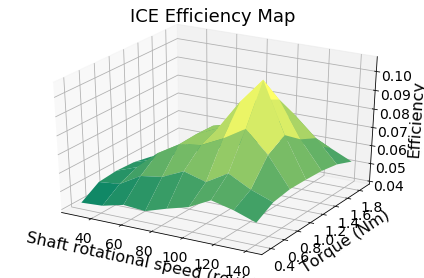

In [10]:
PP['ICEEffFun'] = interp2d(PP['ICEMaprps'], PP['ICEMapTorque'],
                            PP['effMap'])

PlotICEMap(PP)

The simulator object introduced below can autmate the sizing process above if the runSizing argument is set to 'True'. 
Now the aircraft is ready to fly! Complete a short test flight to see the results.

In [11]:
s = simulate(rng=50, plant=PP, runSizing=False)  # create simulate object
TakeOff(s, minimizeTOD=True, fullOutput=True) # run TakeOff. MinimizeTOD=True causes the aircraft to take off in the
                                              # shortest possible distance

Climb(s, v1=25, desiredCR=2, desiredHeight=500, fullOutput=True)  # climb, units in m/s and m

Cruise(s, v1=25, distance=1000, fullOutput=True)  # Cruise, units in m/s and m

Glide(s, desiredHeight=0, fullOutput=True) # descent back to AGL = 0m


----------
-- Take Off --

Expected liftoff v:  17.24  m/s


Lift off achieved in  12.5 s,  
    x1= 71.45 m | v1 = 17.58 m/s 
    x2= 0.65 m | v2 = 0.92 m/s 
    thrust = 58.74 N | pitch = 8.0 degrees
--------

----------
-- CLIMB --
Starting climb at t= 12.5 s,  
    x1= 71.45 m | v1 = 17.58 m/s 
    x2= 0.65 m | v2 = 0.92 m/s 
    desiredCR = 2 m/s
    desired final alt. = 0.5 km 
    thrust setting = 38.62 N 
    pitch setting = 5.68 degrees 

Finished climb at t= 262.69 
    x1= 6317.88 m | v1 = 25.27 m/s
    x2= 499.2 m | v2 = 2.02 m/s
    Distance climbed: 0.5 km 
    time taken to climb: 250.19 s 
    average climb rate: 2.0 m/s

----------

----------
-- CRUISE --
Starting cruise at t= 262.69 s,  
    x1= 6317.88 m | v1 = 25.27 m/s 
    x2= 499.2 m | v2 = 2.02 m/s 
    desired distance = 1.0  km | desired v = 25 m/s 
    Thrust setting = 21.47 N | pitch setting = 1.32 degrees


Finished cruise at t= 304.47 
    x1= 7335.55 m | v1 = 24.97 m/s
    x2= 506.47 m | v2 = -0.01 m/s


Let's plot the velocity components, power-plant behaviour and other data for this flight.

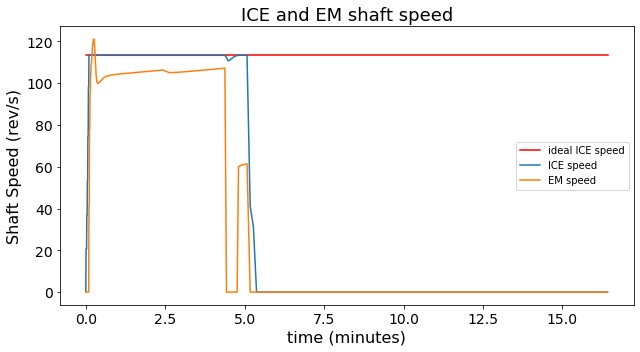

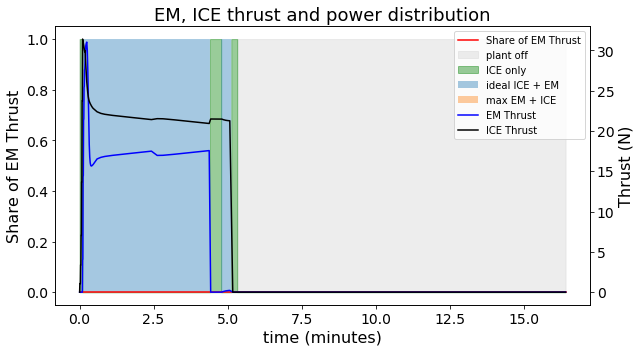

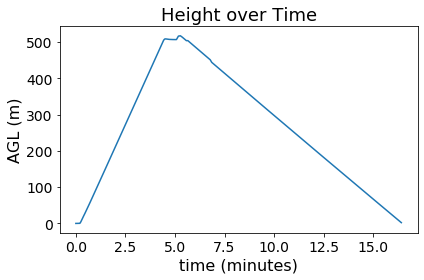

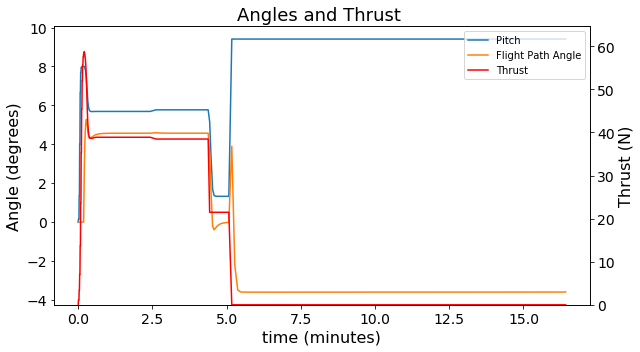

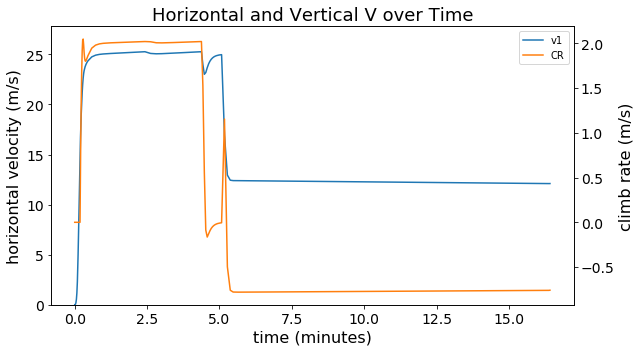

In [12]:
Plot(s, 'plant', 'x2', 'rps', 'thrust', 'pitch', 'gamma', 'v1v2', markers=False)

Let's complete a flight for a transport mission that requires carrying a 5kg payload a distance of 75 km away. Check what the current payload is:

In [13]:
print(AC['payloadMass'], 'kg')

3.0 kg


Let's set the payload to 5kg and make the aircraft fly the mission. The function used for this uses the following equation to satisfy the range requirement: 
$d_{cruise} = required \ range - d_{climb} - h \cdot{} \frac{1}{(L/D)_{MAX}}$

It is implemented as a method within an Optimize object.

In [17]:
op = Optimize(rng=150, plant=PP) # optimization object with a range of 150km and pass it the sized power-plant

# define the velocity components during the climb, the cruise AGL and the cruise velocity
cruiseV1 = 20  # horizontal v component during climb (m/s)
cruiseV2 = 1.5  # climb rate (m/s)
cruiseAlt = 3  # cruise AGL (km)
cruiseV = 25 # cruise velocity (m/s)

massCost = op.CostF([cruiseV1, cruiseV2, cruiseAlt, cruiseV], fullOutput=True, saveSim=True) # perform the flight mission


----------
-- Take Off --

Expected liftoff v:  17.24  m/s


Lift off achieved in  16.5 s,  
    x1= 104.39 m | v1 = 16.84 m/s 
    x2= 0.75 m | v2 = 0.71 m/s 
    thrust = 37.49 N | pitch = 8.0 degrees
--------

----------
-- CLIMB --
Starting climb at t= 16.5 s,  
    x1= 104.39 m | v1 = 16.84 m/s 
    x2= 0.75 m | v2 = 0.71 m/s 
    desiredCR = 1.5 m/s
    desired final alt. = 3.0 km 
    thrust setting = 31.21 N 
    pitch setting = 7.4 degrees 

Finished climb at t= 1974.79 
    x1= 39965.69 m | v1 = 20.71 m/s
    x2= 2987.46 m | v2 = 1.55 m/s
    Distance climbed: 2.99 km 
    time taken to climb: 1958.29 s 
    average climb rate: 1.53 m/s

----------

----------
-- CRUISE --
Starting cruise at t= 1974.79 s,  
    x1= 39965.69 m | v1 = 20.71 m/s 
    x2= 2987.46 m | v2 = 1.55 m/s 
    desired distance = 60.67  km | desired v = 25 m/s 
    Thrust setting = 17.76 N | pitch setting = 2.4 degrees


Finished cruise at t= 4558.03 
    x1= 104472.84 m | v1 = 25.0 m/s
    x2= 2984.92 m

The CostF function returns the equivalent mass cost of the flight given by:
$ mass cost = \frac{1}{LCV} \int_{0}^{t} P_{Cost, ICE} \ dt + \frac{1}{e_{battery}} \int_{0}^{t} P_{Cost, EM} \ dt $

Print this value and the distance at which the payload was dropped. Plot the flight.

Equivalent mass cost of the mission: 1.9591 kg
Payload dropped 78.79 km from take-off point


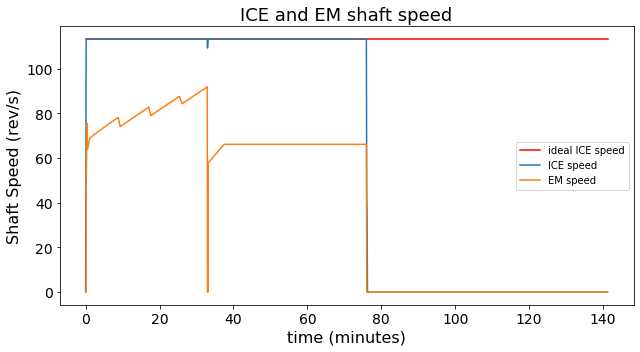

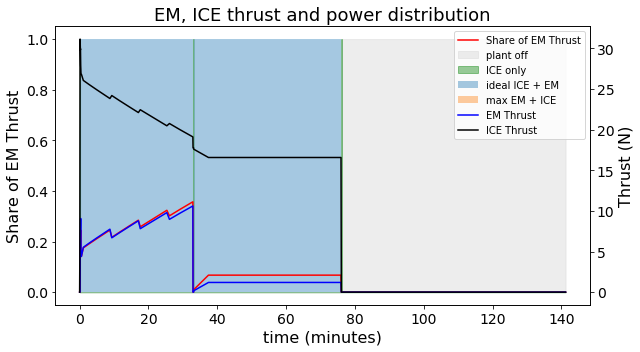

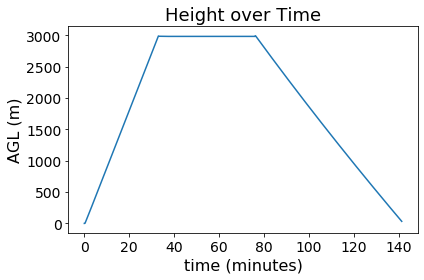

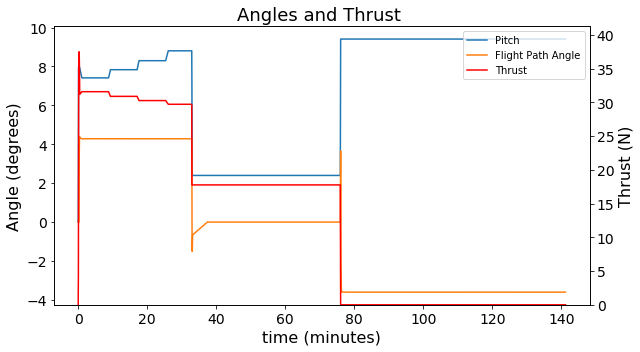

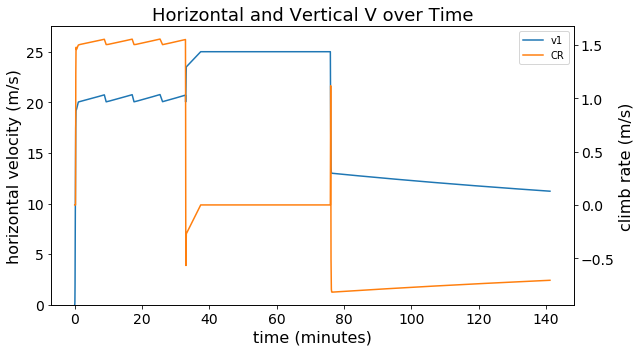

In [21]:
print('Equivalent mass cost of the mission:', round(massCost, 4), 'kg')
print('Payload dropped', round(op.sim.payloadDropped/1000, 2), "km from take-off point")
Plot(op.sim, 'plant', 'x2', 'rps', 'thrust', 'pitch', 'gamma', 'v1v2', markers=False)

However, this flight profile is not ideal. The 4 values passed to CostF can be optimized using the optm method of the Optimize object. This implements a trust constraint optimisation algorithm that uses CostF as an objective function and will take a while to run.

In [24]:
op = Optimize(150, PP)
result = op.optm()  # this will print the number of objective function calls performed to track the progress

10
20
30
40
50
60
70
80
90
100
100


Get some data from the optimized flight profile. The plot showing the SOC and remaining fuel reveal that the aircraft was carrying a battery that is too large and too much fuel.

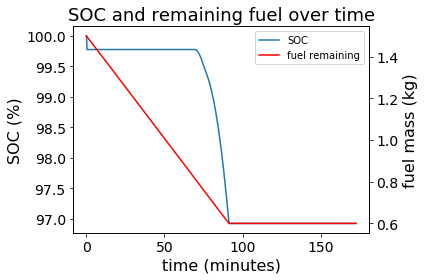

The battery mass cost for the optimised flight profile is 0.05 kg and the fuel mass cost is 0.9 kg. Compare to a total mass cost of 1.9590542555997374 kg from the arbitrary flight profile earlier.


In [27]:
op.CostF(result.x, saveSim=True)

fuelMassCost = op.sim.fuelMassCost[op.sim.n-1]
battMassCost = op.sim.battMassCost[op.sim.n-1]

Plot(op.sim, 'soc', markers=False)

print('The battery mass cost for the optimised flight profile is', round(battMassCost, 2), 'kg and the fuel mass cost is',
     round(fuelMassCost, 2), 'kg. Compare to a total mass cost of', round(massCost,2), 'kg from the arbitrary flight profile earlier.')

The large battery chosen at the beginning is therefore not necessary. The smallest battery has sufficient capacity for this flight. Similarly, the fuel tank does not have to carry 1.5kg of fuel. Update these values, print the mass savings and run the optimisation again:

In [30]:
massSavings = PP['battMassList'][4] - PP['battMassList'][0] + PP['fullTankMass'] - fuelMassCost

PP['battChoice'] = 0
PP['fullTankMass'] = fuelMassCost

print('Mass savings: ', round(massSavings, 2), 'kg')

Mass savings:  1.61 kg


The optimisation can now be run again with the lower mass.

In [29]:
op2 = Optimize(150, PP)
result2 = op2.optm()

10
20
30
40
50
60
70
80
90
100
110
115


Plot and print some info about this final flight profile. With the smaller battery and less fuel on board, the SOC and remaining fuel plot comes closer to zero at the end of the flight.

Mass savings compared to first optimisation:  0.06 kg


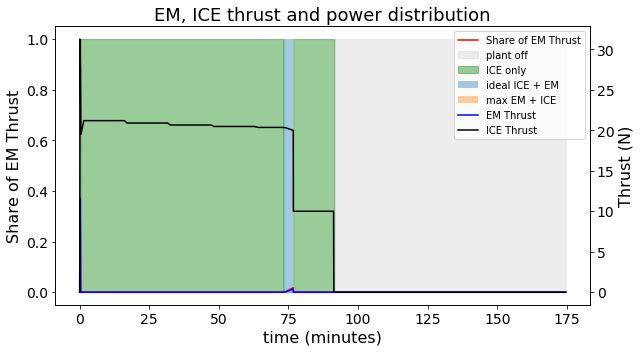

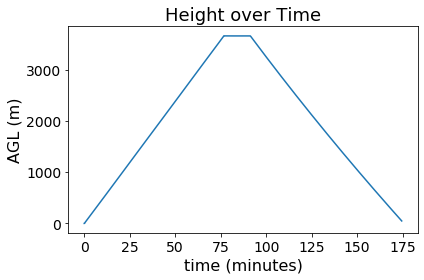

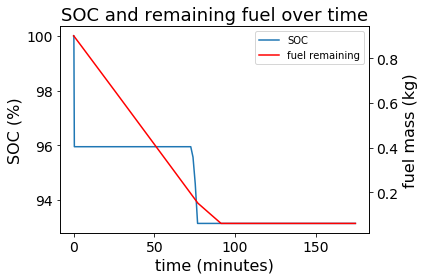

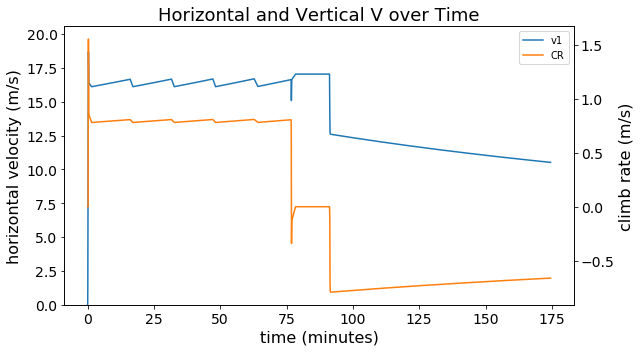

In [33]:
op2.CostF(result2.x, saveSim=True)
fuelMassCost = op2.sim.fuelMassCost[op2.sim.n-1]
massSavings = PP['fullTankMass'] - fuelMassCost

print('Mass savings compared to first optimisation: ', round(massSavings, 2), 'kg')

Plot(op2.sim, 'soc', 'plant', 'x2', 'v1v2', markers=False)

The process demonstrated in this notebook can be exectuted automatically by calling the Results function from the flight_optimizer module. The user input can be entirely confined to a .txt file following the format of the aircraft_params.txt file utilised here.

In [ ]:
from flight_optimizer import Results

Results(rng=150)

10
20
30
40
